In [2]:
import sys, os
import numpy as np
import pickle
import tensorflow as tf
import multiprocessing
import glob
from tqdm import tqdm
from waymo_open_dataset.protos import scenario_pb2
from waymo_types import object_type, lane_type, road_line_type, road_edge_type, signal_state, polyline_type
import matplotlib.path as mpath
import matplotlib.pyplot as plt

2024-03-20 10:56:01.149683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 10:56:01.203256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 10:56:01.456766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: “/usr/local/cuda-12.0/lib64:/usr/local/lib/:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humb

In [5]:
example_file = '/home/erik/raid/datasets/womd/processed_scenarios_training/sample_882d8df85189a2c0.pkl'
#training_infos_file = '/home/erik/raid/datasets/womd/processed_scenarios_training_infos.pkl'
# with open(training_infos_file, 'rb') as f:
#     training_infos = pickle.load(f)
with open(example_file, 'rb') as f:
    example = pickle.load(f)
print(example.keys())
print(example['track_infos']['trajs'].shape)
print(len(example['track_infos']['object_id']))
print(example['map_infos'].keys())
# print(training_infos[0].keys())
print(example['track_infos']['object_type'])
print(type(example['scenario_id']))

dict_keys(['track_infos', 'dynamic_map_infos', 'map_infos', 'scenario_id', 'timestamps_seconds', 'current_time_index', 'sdc_track_index', 'objects_of_interest', 'tracks_to_predict'])
(80, 91, 10)
80
dict_keys(['lane', 'road_line', 'road_edge', 'stop_sign', 'crosswalk', 'driveway', 'speed_bump', 'all_polylines'])
['TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_PEDESTRIAN', 'TYPE_CYCLIST', 'TYPE_CYCLIST', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEH

In [4]:
def check_for_vru(track_infos):
    peds = False
    cyclists = False
    for type in track_infos['object_type']:
        if type == 'TYPE_PEDESTRIAN':
            peds = True
        elif type == 'TYPE_CYCLIST':
            cyclists = True
        if peds and cyclists:
            break
    return peds, cyclists

def check_distance_to_vehicles(track_infos):
    vehicle_trajectories = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_VEHICLE', :, :3]
    distances_per_type = dict()
    distances_per_type['TYPE_PEDESTRIAN'] = np.inf
    distances_per_type['TYPE_CYCLIST'] = np.inf
    for i, type in enumerate(track_infos['object_type']):
        if type == 'TYPE_VEHICLE':
            continue
        elif type == 'TYPE_PEDESTRIAN' or type == 'TYPE_CYCLIST':
            ref_trajectory = track_infos['trajs'][i, :, :3]
            differences = vehicle_trajectories - ref_trajectory[np.newaxis, :, :]
            distances = np.linalg.norm(differences, axis=2)
            masked_distances = np.ma.masked_equal(distances, 0.0)
            # print(distances.shape)
            min_distance_per_agent = np.min(masked_distances, axis=1)
            #print(min_distance_per_agent)
            min_distance = np.min(min_distance_per_agent, axis=0)
            if min_distance < distances_per_type[type]:
                distances_per_type[type] = min_distance
    return distances_per_type

def check_for_crosswalk(map_infos):
    return len(map_infos['crosswalk']) > 0

def check_vru_on_crosswalk(track_infos, map_infos):
    ped_trajectories = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_PEDESTRIAN', :, :2]
    polygons = list()
    for crosswalk in map_infos['crosswalk']:
        polyline_indices = crosswalk['polyline_index']
        polygons.append(map_infos['all_polylines'][polyline_indices[0]:polyline_indices[1]+1][:, :2])
    polygon_paths = [mpath.Path(polygon) for polygon in polygons]
    for ped_index, trajectory in enumerate(ped_trajectories):
        for position in trajectory:
            for poly_index, polygon_path in enumerate(polygon_paths):
                if polygon_path.contains_point(position):
                    return True
    return False

def check_for_high_acceleration_and_jerk(track_infos):
    ped_velocities = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_PEDESTRIAN', :, 7:9]
    if ped_velocities.shape[0] > 0:
        ped_accelerations = np.diff(ped_velocities, axis=1)
        #print(f'After diff: {ped_accelerations.shape}')
        ped_jerk = np.diff(ped_accelerations, axis=1)
        ped_jerk = np.linalg.norm(ped_jerk, axis=-1)
        ped_accelerations = np.linalg.norm(ped_accelerations, axis=-1)
        #print(f'After norm: {ped_accelerations.shape}')
        max_ped_acceleration = np.max(np.max(ped_accelerations, axis=-1))
        max_ped_jerk = np.max(np.max(ped_jerk, axis=-1))
        min_ped_acceleration = np.min(np.min(ped_accelerations, axis=-1))
        min_ped_jerk = np.min(np.min(ped_jerk, axis=-1))
    else:
        max_ped_acceleration = 0
        max_ped_jerk = 0
        min_ped_acceleration = 0
        min_ped_jerk = 0

    veh_velocities = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_VEHICLE', :, 7:9]
    if veh_velocities.shape[0] > 0:
        veh_accelerations = np.diff(veh_velocities, axis=1)
        #print(f'After diff: {veh_accelerations.shape}')
        veh_jerk = np.diff(veh_accelerations, axis=1)
        veh_jerk = np.linalg.norm(veh_jerk, axis=-1)
        veh_accelerations = np.linalg.norm(veh_accelerations, axis=-1)
        #print(f'After norm: {veh_accelerations.shape}')
        max_veh_acceleration = np.max(np.max(veh_accelerations, axis=-1))
        max_veh_jerk = np.max(np.max(veh_jerk, axis=-1))
        min_veh_acceleration = np.min(np.min(veh_accelerations, axis=-1))
        min_veh_jerk = np.min(np.min(veh_jerk, axis=-1))
    else:
        max_veh_acceleration = 0
        max_veh_jerk = 0
        min_veh_acceleration = 0
        min_veh_jerk = 0

    cyclist_velocities = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_CYCLIST', :, 7:9]
    if cyclist_velocities.shape[0] > 0:
        cyclist_accelerations = np.diff(cyclist_velocities, axis=1)
        cyclist_jerk = np.diff(cyclist_accelerations, axis=1)
        cyclist_jerk = np.linalg.norm(cyclist_jerk, axis=-1)
        cyclist_accelerations = np.linalg.norm(cyclist_accelerations, axis=-1)
        max_cyclist_acceleration = np.max(np.max(cyclist_accelerations, axis=-1))
        max_cyclist_jerk = np.max(np.max(cyclist_jerk, axis=-1))
        min_cyclist_acceleration = np.min(np.min(cyclist_accelerations, axis=-1))
        min_cyclist_jerk = np.min(np.min(cyclist_jerk, axis=-1))
    else:
        max_cyclist_acceleration = 0
        max_cyclist_jerk = 0
        min_cyclist_acceleration = 0
        min_cyclist_jerk = 0

    return max_ped_acceleration, max_ped_jerk, min_ped_acceleration, min_ped_jerk, max_veh_acceleration, max_veh_jerk, min_veh_acceleration, min_veh_jerk, max_cyclist_acceleration, max_cyclist_jerk, min_cyclist_acceleration, min_cyclist_jerk

def check_distance_to_road_edge(track_infos, map_infos):
    ped_trajectories = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_PEDESTRIAN', :, :2]
    num_peds = ped_trajectories.shape[0]
    overall_min_distance = np.inf
    for edge in map_infos['road_edge']:
        if edge['type'] == 'TYPE_ROAD_EDGE_BOUNDARY':
            road_edges = map_infos['all_polylines'][edge['polyline_index'][0]:edge['polyline_index'][1]+1][:, :2]
            num_points = road_edges.shape[0]
            min_distances = np.inf * np.ones(num_peds)
            for i in range(num_peds):
                sq_dists = np.sum((ped_trajectories[i, :, np.newaxis, :] - road_edges[np.newaxis, :, :])**2, axis=-1)
                min_sq_dist = np.min(sq_dists)

                min_distances[i] = np.sqrt(min_sq_dist)
            min_distance = np.min(min_distances)
            if min_distance < overall_min_distance:
                overall_min_distance = min_distance
    return overall_min_distance

def check_for_cyclist_turn(track_infos):
    cyclist_heading = track_infos['trajs'][np.array(track_infos['object_type']) == 'TYPE_CYCLIST', :, 6]
    num_cyclists = cyclist_heading.shape[0]
    num_timesteps = cyclist_heading.shape[1]
    first_heading = np.repeat(cyclist_heading[:, 0][:, np.newaxis], num_timesteps, axis=1)
    diff = np.abs(cyclist_heading - first_heading)
    maximum_diff = np.max(np.max(diff, axis=-1))
    return maximum_diff

    

    

In [7]:
distances = check_distance_to_vehicles(example['track_infos'])
print(distances)
dynamic_infos = check_for_high_acceleration_and_jerk(example['track_infos'])
print(dynamic_infos)
print(check_distance_to_road_edge(example['track_infos'], example['map_infos']))
print(check_for_cyclist_turn(example['track_infos']))

{'TYPE_PEDESTRIAN': 2.2126758, 'TYPE_CYCLIST': 5.85942}
After diff: (13, 90, 2)
After norm: (13, 90)
After diff: (65, 90, 2)
After norm: (65, 90)
(5.3130875, 10.626175, 0.0, 0.0, 14.729785, 14.911922, 0.0, 0.0, 5.1271014, 5.5014386, 0.0, 0.0)
1.2250285148620605
4.6602964


In [6]:
# Iterate through dataset
path_to_womd = '/home/erik/raid/datasets/womd'
scenarios = glob.glob(os.path.join(path_to_womd, 'processed_scenarios_training', '*.pkl'))
vru_infos = dict()
for scenario in tqdm(scenarios):
    with open(scenario, 'rb') as f:
        scenario_dict = pickle.load(f)
    vru_presence = check_for_vru(scenario_dict['track_infos'])
    vru_infos[scenario_dict['scenario_id']] = dict()
    vru_infos[scenario_dict['scenario_id']]['pedestrians'] = vru_presence[0]
    vru_infos[scenario_dict['scenario_id']]['cyclists'] = vru_presence[1]
    if vru_presence[0] or vru_presence[1]:
        distances = check_distance_to_vehicles(scenario_dict['track_infos'])
        vru_infos[scenario_dict['scenario_id']]['distances'] = distances
    else:
        vru_infos[scenario_dict['scenario_id']]['distances'] = None
    if vru_presence[0]:
        vru_infos[scenario_dict['scenario_id']]['distance_to_road_edge'] = check_distance_to_road_edge(scenario_dict['track_infos'], scenario_dict['map_infos'])
    else:
        vru_infos[scenario_dict['scenario_id']]['distance_to_road_edge'] = None
    if vru_presence[1]:
        vru_infos[scenario_dict['scenario_id']]['cyclist_turn'] = check_for_cyclist_turn(scenario_dict['track_infos'])
    else:
        vru_infos[scenario_dict['scenario_id']]['cyclist_turn'] = None
    if check_for_crosswalk(scenario_dict['map_infos']):
        vru_infos[scenario_dict['scenario_id']]['crosswalk'] = True
        if vru_presence[0]:
            if check_vru_on_crosswalk(scenario_dict['track_infos'], scenario_dict['map_infos']):
                vru_infos[scenario_dict['scenario_id']]['vru_on_crosswalk'] = True
            else:
                vru_infos[scenario_dict['scenario_id']]['vru_on_crosswalk'] = False
        else:
            vru_infos[scenario_dict['scenario_id']]['vru_on_crosswalk'] = False
    else:
        vru_infos[scenario_dict['scenario_id']]['crosswalk'] = False
    max_ped_acceleration, max_ped_jerk, min_ped_acceleration, min_ped_jerk, max_veh_acceleration, max_veh_jerk, min_veh_acceleration, min_veh_jerk, max_cyclist_acceleration, max_cyclist_jerk, min_cyclist_acceleration, min_cyclist_jerk = check_for_high_acceleration_and_jerk(scenario_dict['track_infos'])
    vru_infos[scenario_dict['scenario_id']]['max_ped_acceleration'] = max_ped_acceleration
    vru_infos[scenario_dict['scenario_id']]['max_ped_jerk'] = max_ped_jerk
    vru_infos[scenario_dict['scenario_id']]['min_ped_acceleration'] = min_ped_acceleration
    vru_infos[scenario_dict['scenario_id']]['min_ped_jerk'] = min_ped_jerk
    vru_infos[scenario_dict['scenario_id']]['max_veh_acceleration'] = max_veh_acceleration
    vru_infos[scenario_dict['scenario_id']]['max_veh_jerk'] = max_veh_jerk
    vru_infos[scenario_dict['scenario_id']]['min_veh_acceleration'] = min_veh_acceleration
    vru_infos[scenario_dict['scenario_id']]['min_veh_jerk'] = min_veh_jerk
    vru_infos[scenario_dict['scenario_id']]['max_cyclist_acceleration'] = max_cyclist_acceleration
    vru_infos[scenario_dict['scenario_id']]['max_cyclist_jerk'] = max_cyclist_jerk
    vru_infos[scenario_dict['scenario_id']]['min_cyclist_acceleration'] = min_cyclist_acceleration
    vru_infos[scenario_dict['scenario_id']]['min_cyclist_jerk'] = min_cyclist_jerk
with open('vru_infos.pkl', 'wb') as f:
    pickle.dump(vru_infos, f)
    

  0%|          | 1387/486995 [01:04<7:59:56, 16.86it/s] 

100%|██████████| 486995/486995 [00:00<00:00, 891101.47it/s]


Number of scenarios with pedestrians: 372749
Number of scenarios with cyclists: 120658
Number of scenarios with crosswalks: 457342
Number of scenarios with VRU on crosswalks: 170894


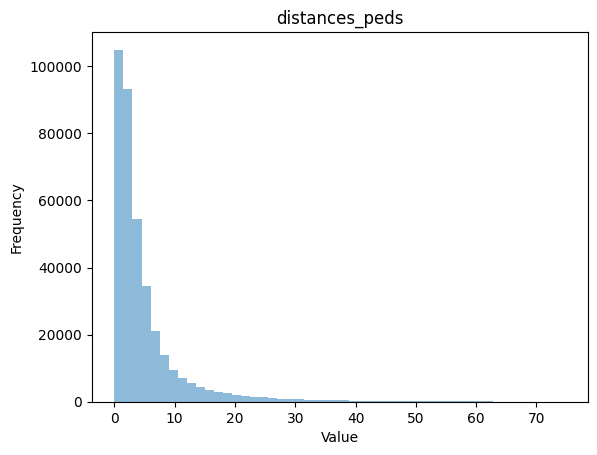

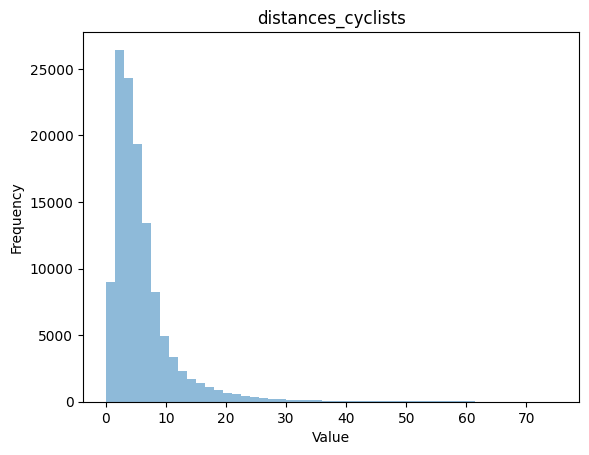

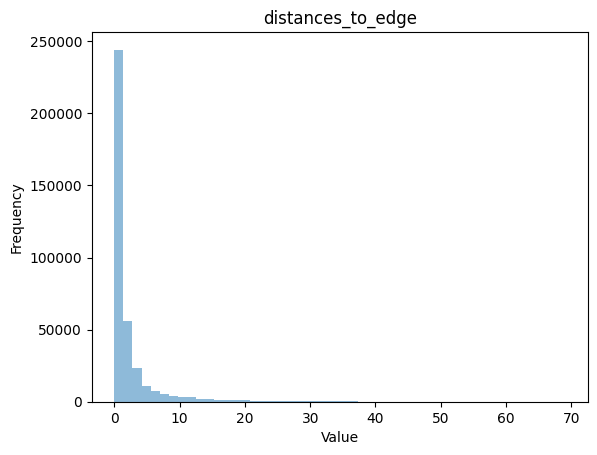

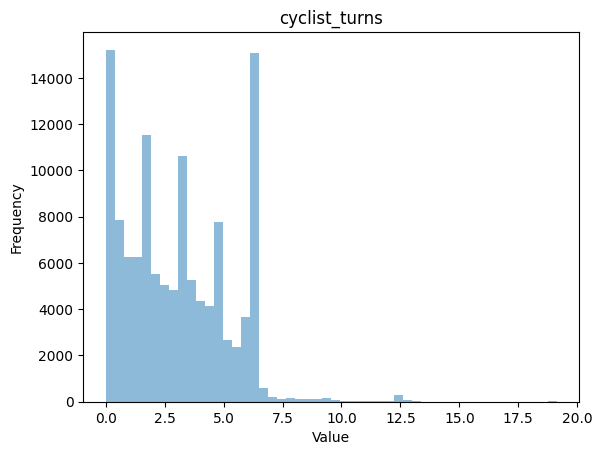

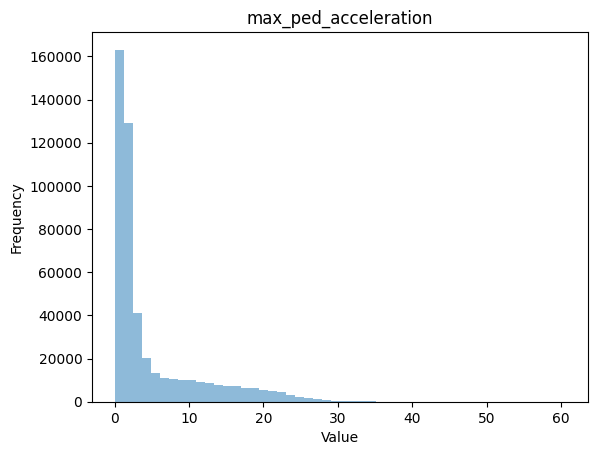

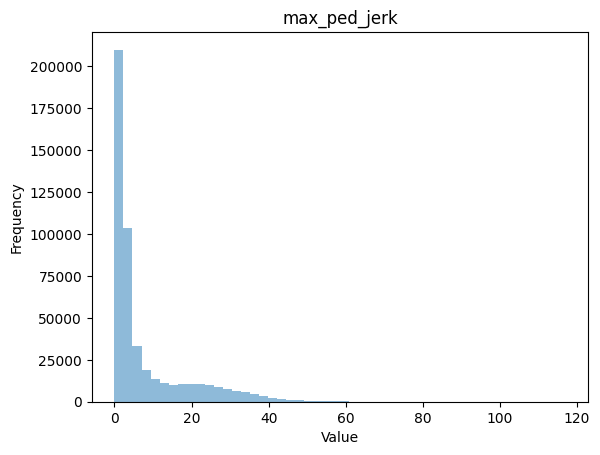

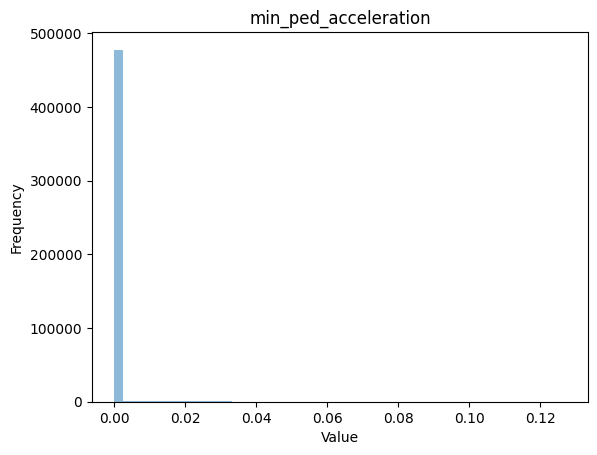

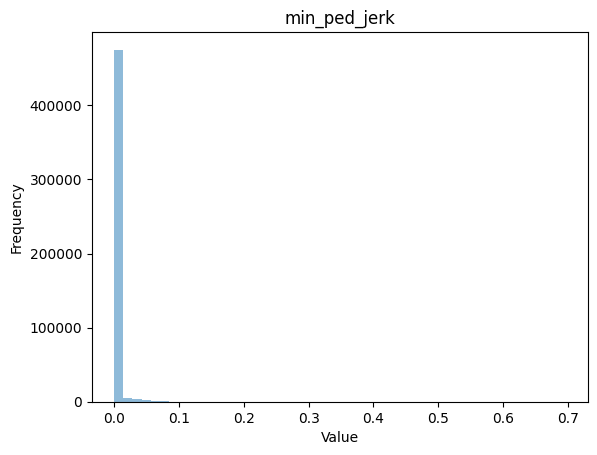

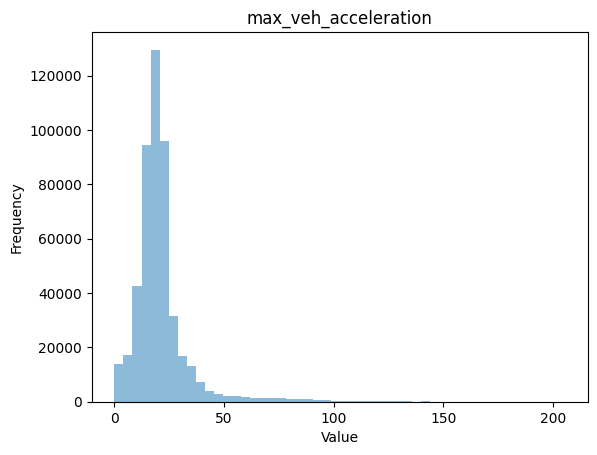

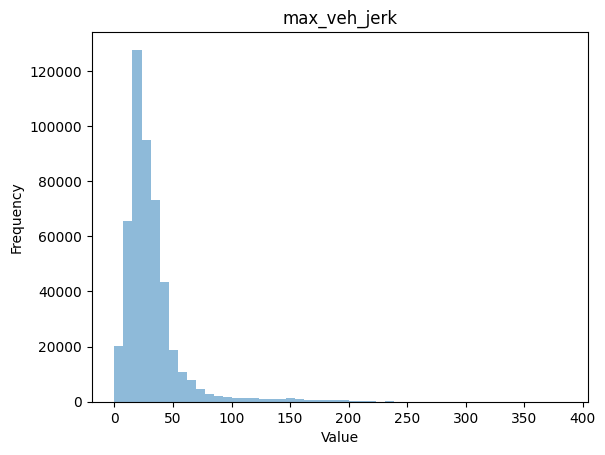

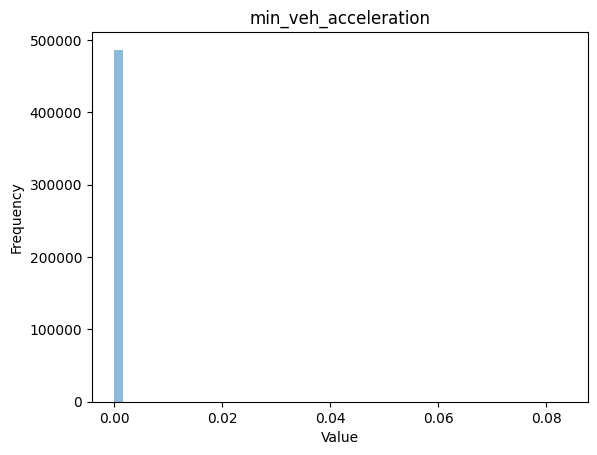

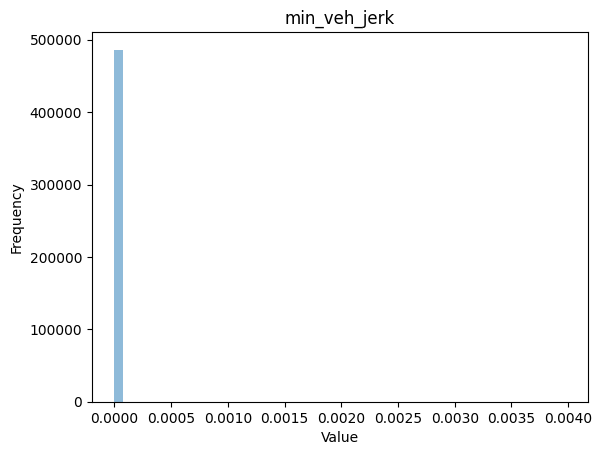

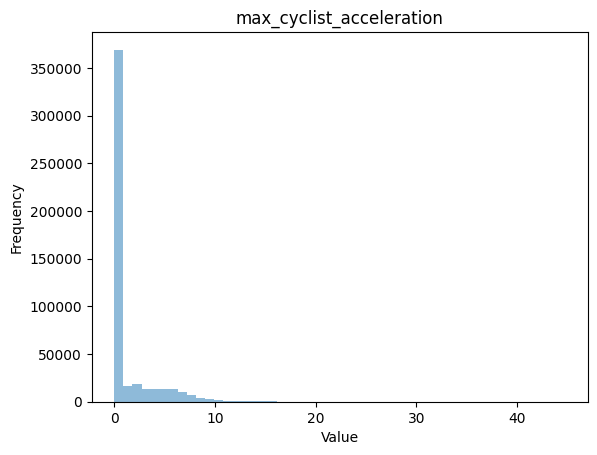

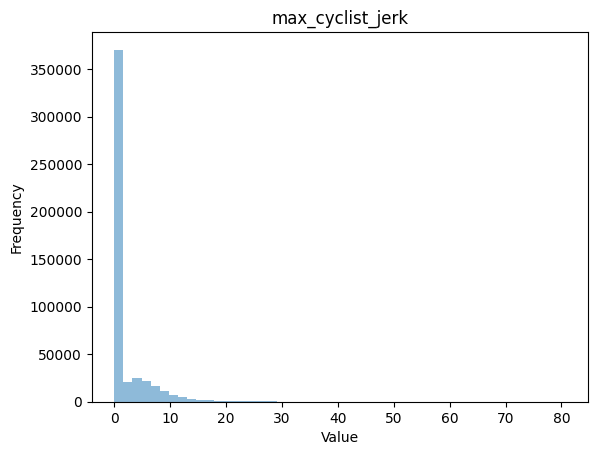

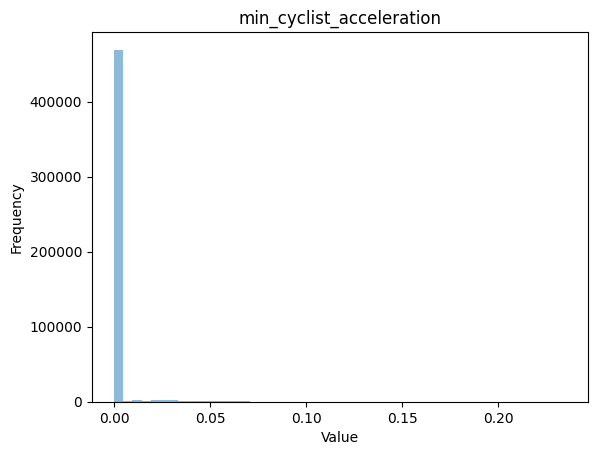

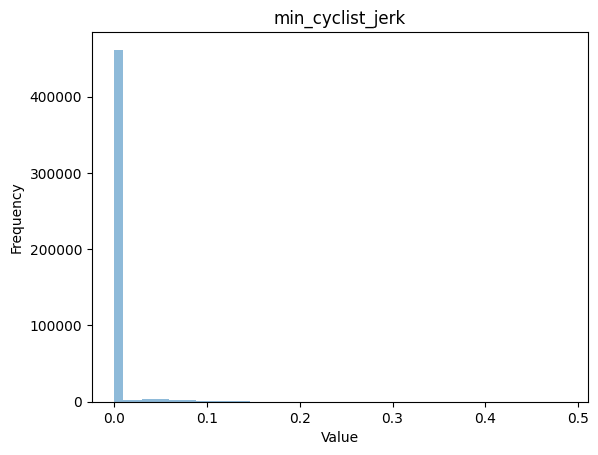

In [26]:
with open('vru_infos.pkl', 'rb') as f:
    vru_infos = pickle.load(f)
num_peds = 0
num_cyclists = 0
distances_peds = list()
distances_cyclists = list()
distances_to_edge = list()
cyclist_turns = list()
num_crosswalks = 0
vru_on_crosswalks = 0
max_ped_acceleration = list()
max_ped_jerk = list()
min_ped_acceleration = list()
min_ped_jerk = list()
max_veh_acceleration = list()
max_veh_jerk = list()
min_veh_acceleration = list()
min_veh_jerk = list()
max_cyclist_acceleration = list()
max_cyclist_jerk = list()
min_cyclist_acceleration = list()
min_cyclist_jerk = list()
for key in tqdm(vru_infos.keys()):
    if vru_infos[key]['pedestrians']:
        num_peds += 1
    if vru_infos[key]['cyclists']:
        num_cyclists += 1
    if vru_infos[key]['distances'] is not None:
        distances_peds.append(vru_infos[key]['distances']['TYPE_PEDESTRIAN'])
        distances_cyclists.append(vru_infos[key]['distances']['TYPE_CYCLIST'])
    if vru_infos[key]['distance_to_road_edge'] is not None:
        distances_to_edge.append(vru_infos[key]['distance_to_road_edge'])
    if vru_infos[key]['crosswalk']:
        num_crosswalks += 1
    if 'vru_on_crosswalk' in vru_infos[key].keys():
        if vru_infos[key]['vru_on_crosswalk']:
            vru_on_crosswalks += 1
    if vru_infos[key]['cyclists']:
        if vru_infos[key]['cyclist_turn'] is not None:
            cyclist_turns.append(vru_infos[key]['cyclist_turn'])
    max_ped_acceleration.append(vru_infos[key]['max_ped_acceleration'])
    max_ped_jerk.append(vru_infos[key]['max_ped_jerk'])
    min_ped_acceleration.append(vru_infos[key]['min_ped_acceleration'])
    min_ped_jerk.append(vru_infos[key]['min_ped_jerk'])
    max_veh_acceleration.append(vru_infos[key]['max_veh_acceleration'])
    max_veh_jerk.append(vru_infos[key]['max_veh_jerk'])
    min_veh_acceleration.append(vru_infos[key]['min_veh_acceleration'])
    min_veh_jerk.append(vru_infos[key]['min_veh_jerk'])
    max_cyclist_acceleration.append(vru_infos[key]['max_cyclist_acceleration'])
    max_cyclist_jerk.append(vru_infos[key]['max_cyclist_jerk'])
    min_cyclist_acceleration.append(vru_infos[key]['min_cyclist_acceleration'])
    min_cyclist_jerk.append(vru_infos[key]['min_cyclist_jerk'])
print(f'Number of scenarios with pedestrians: {num_peds}')
print(f'Number of scenarios with cyclists: {num_cyclists}')
print(f'Number of scenarios with crosswalks: {num_crosswalks}')
print(f'Number of scenarios with VRU on crosswalks: {vru_on_crosswalks}')

lists_to_plot = [np.array(distances_peds)[np.isfinite(distances_peds)], np.array(distances_cyclists)[np.isfinite(distances_cyclists)], np.array(distances_to_edge)[np.isfinite(distances_to_edge)], cyclist_turns, max_ped_acceleration, max_ped_jerk, min_ped_acceleration, min_ped_jerk, max_veh_acceleration, max_veh_jerk, min_veh_acceleration, min_veh_jerk, max_cyclist_acceleration, max_cyclist_jerk, min_cyclist_acceleration, min_cyclist_jerk]

list_names = ['distances_peds', 'distances_cyclists', 'distances_to_edge', 'cyclist_turns', 'max_ped_acceleration', 'max_ped_jerk', 'min_ped_acceleration', 'min_ped_jerk', 'max_veh_acceleration', 'max_veh_jerk', 'min_veh_acceleration', 'min_veh_jerk', 'max_cyclist_acceleration', 'max_cyclist_jerk', 'min_cyclist_acceleration', 'min_cyclist_jerk']

for i, list_to_plot in enumerate(lists_to_plot):
    plt.figure()
    plt.hist(list_to_plot, bins=50, alpha=0.5)
    plt.title(list_names[i])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

    

In [24]:
print(len(np.array(distances_peds)[np.isfinite(distances_peds)]))

372749
